Importing libraries
1. Loading Images and creating utility function for data augmentation
2. Image demostration

CNN models

1. ResNet50V2
Training without data augmentation
Further tune the model with data augmentation

2. VGG19
Training without data augmentation
Further tune the model with data augmentation

3. InceptionV3
Training without data augmentation
Further tune the model with data augmentation

Importing the libraries

Numpy and pandas for data analysis

plotlib and seaborn for data exploration

sklearn metrics for measuring the performance of the model

tensorflow and keras for building our models


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#intializing the image size and batch size
height = 244
width = 244
batch_size=32

In [ ]:
dataset_dir = "/content/drive/MyDrive/brain_tumor_dataset"

def image_gen(height, width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.2,
            )
    train_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        subset="training",
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'no': 0., 'yes': 1.}
    )
    
    val_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        subset="validation",
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'no': 0., 'yes': 1.}
    )
    
    return train_ds, val_ds
    

def augmented_data(height, width):
    datagen = ImageDataGenerator(
        rescale= 1./255.,
        width_shift_range= 0.1,
        height_shift_range=0.1, 
        shear_range=0.1,
        zoom_range=0.1,
        rotation_range=30,
        horizontal_flip=True,
        brightness_range=(0.5, 1.0)
    )
    
    train_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'no': 0., 'yes': 1.}
    )
    
    return train_ds

train_ds, val_ds = image_gen(height, width)

total_images = np.concatenate([train_ds.labels, val_ds.labels])
print('\n\n',{"No brain tumor cases": len(np.where(total_images==0)[0]),
             "Brain tumor cases": len(np.where(total_images==1)[0])})

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


 {'No brain tumor cases': 98, 'Brain tumor cases': 155}


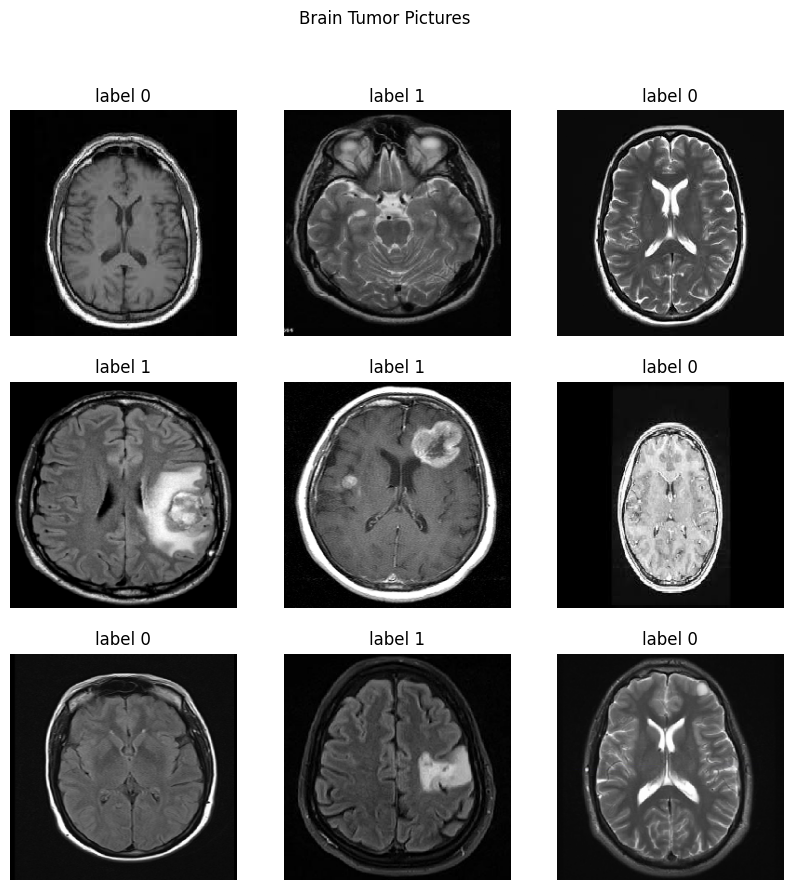

In [ ]:
fig, ax = plt.subplots(3,3, figsize=(10,10))
fig.suptitle("Brain Tumor Pictures")

for k in range(9):
    images, labels = train_ds.next()
    #print(images[0].shape)
    i, j = k//3, k%3
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f"label {int(labels[0])}")
    ax[i, j].axis('off')
plt.show()


ResNet50V2

We will use ResNet50V2 pre-trained model from keras. You can read more details about it from here. We will use the pre-trained model as base model and will build a final segement with a GlobalAveragePooling2D layer, Flatten layer, 2 Dense layer and a Dropout layer. We will use softmax activation for our output layer.

In [ ]:
from keras.applications import ResNet50V2
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.models import Sequential, load_model

In [ ]:
#Declaring base model
tf.keras.backend.clear_session()

base_model = ResNet50V2(input_shape=(244,244,3), include_top=False)
base_model.trainable = False

model1 = Sequential([
    base_model, 
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(256, activation="relu", kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model1.compile(optimizer=Adam(), 
               loss="sparse_categorical_crossentropy", 
               metrics=['accuracy'])

model1.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 51

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/resnet50v2_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model1.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks_list)

Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 0.7323 - accuracy: 0.7192
Epoch 1: accuracy improved from -inf to 0.71921, saving model to model/resnet50v2_best.h5
7/7 [==============================] - 69s 9s/step - loss: 0.7323 - accuracy: 0.7192 - val_loss: 0.2976 - val_accuracy: 0.8800
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 0.2992 - accuracy: 0.8768
Epoch 2: accuracy improved from 0.71921 to 0.87685, saving model to model/resnet50v2_best.h5
7/7 [==============================] - 66s 10s/step - loss: 0.2992 - accuracy: 0.8768 - val_loss: 0.2834 - val_accuracy: 0.8800
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 0.2150 - accuracy: 0.9064
Epoch 3: accuracy improved from 0.87685 to 0.90640, saving model to model/resnet50v2_best.h5
7/7 [==============================] - 55s 8s/step - loss: 0.2150 - accuracy: 0.9064 - val_loss: 0.4138 - val_accuracy: 0.8600
Epoch 4/30
7/7 [==============================] - ETA: 0s - loss: 

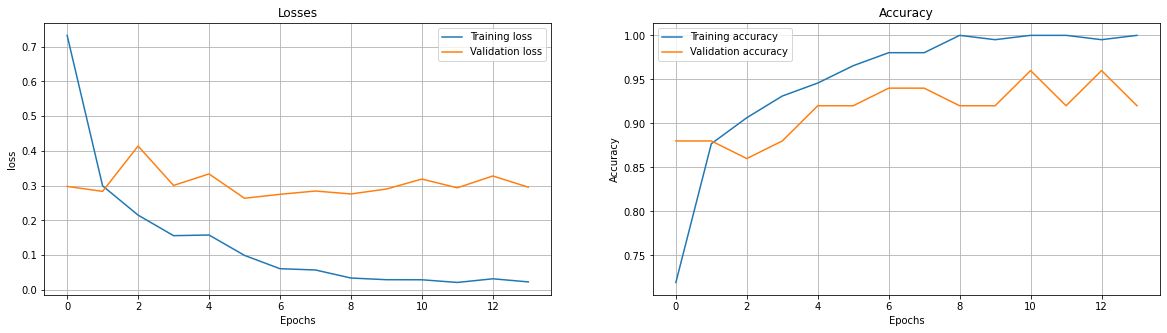

In [ ]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [ ]:
aug_train_ds = augmented_data(height, width)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3,
                                                 patience=2, min_lr=0.0000001)
callbacks_list = [checkpoint,early,reduce_lr]

history = model1.fit(aug_train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks_list)

Found 253 images belonging to 2 classes.
Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 0.4236 - accuracy: 0.8458
Epoch 1: accuracy did not improve from 1.00000
8/8 [==============================] - 80s 10s/step - loss: 0.4236 - accuracy: 0.8458 - val_loss: 0.3085 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 0.3244 - accuracy: 0.8696
Epoch 2: accuracy did not improve from 1.00000
8/8 [==============================] - 69s 9s/step - loss: 0.3244 - accuracy: 0.8696 - val_loss: 0.4221 - val_accuracy: 0.8600 - lr: 0.0010
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 0.2289 - accuracy: 0.9051
Epoch 3: accuracy did not improve from 1.00000
8/8 [==============================] - 71s 9s/step - loss: 0.2289 - accuracy: 0.9051 - val_loss: 0.1310 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 0.1938 - accuracy: 0.9130
Epoch 4: accuracy did not imp

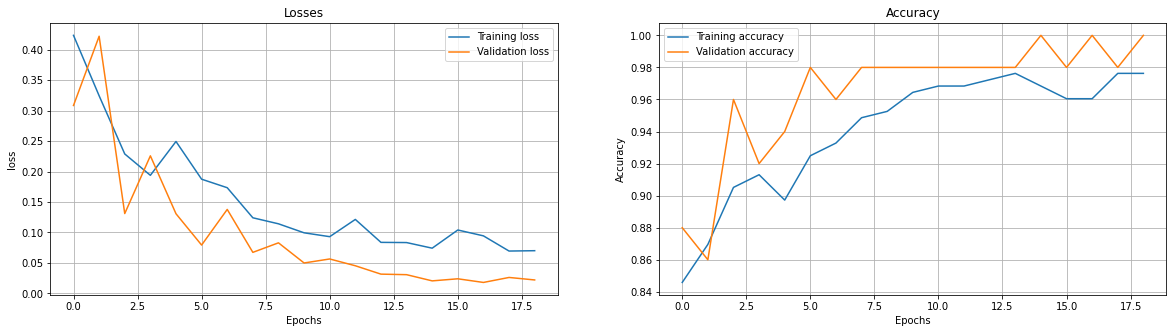

In [ ]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [ ]:
train_result = model1.evaluate(train_ds)
val_result = model1.evaluate(val_ds)

model1_result = pd.DataFrame(zip(train_result, val_result), 
                             columns=['Train', 'Validation'], 
                             index=['Loss', "Accuracy"])

model1_result

2/2 [==============================] - 9s 3s/step - loss: 0.0307 - accuracy: 0.9800


,Train,Validation
Loss,0.027363,0.030678
Accuracy,0.995074,0.980000


In [ ]:
y_pred = model1.predict(val_ds[0][0])
y_pred = np.argmax(y_pred, axis=-1)

y_test = val_ds[0][-1]

#print(y_pred.shape)
#print(y_test.shape)
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score: ", accuracy_score(y_test,y_pred))
print("Classification report:\n", classification_report(y_pred,y_test))

1/1 [==============================] - 8s 8s/step
Confusion matrix:
 [[14  0]
 [ 1 17]]
Accuracy Score:  0.96875
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.94      1.00      0.97        17

    accuracy                           0.97        32
   macro avg       0.97      0.97      0.97        32
weighted avg       0.97      0.97      0.97        32



<Axes: >

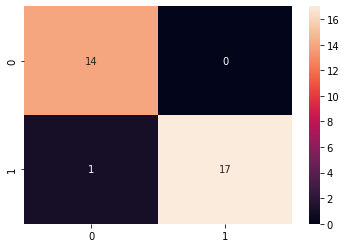

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

2. VGG19

We will use VGG19 pre-trained model from keras. You can read more details about it from here. We will use the pre-trained model as base model and will build a final segement with a Flatten layer and a Dense layer. We will use sigmoid activation for our output layer. For VGG19, we will use image size of 224*224.

In [ ]:
from keras.applications.vgg19 import VGG19
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam

In [ ]:
tf.keras.backend.clear_session()

#initializing new height and width for images
height=224
width=224

train_ds, val_ds = image_gen(height, width)

base_model = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(height,width,3)
)

base_model.trainable = False

model2 = Sequential([
    base_model,
    #GlobalAveragePooling2D(),
    Flatten(),
    #Dense(256, activation="relu", kernel_initializer='he_normal'),
    Dense(1, activation='sigmoid')
])

model2.summary()

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
model2.compile(loss="binary_crossentropy", 
               optimizer=Adam(0.01), metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg19_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max",
                                         restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model2.fit(train_ds, 
           validation_data=val_ds,
           epochs=30,
           shuffle=True,
           verbose=True,
           callbacks=callbacks_list
          )

Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 2.7471 - accuracy: 0.6847 
Epoch 1: accuracy improved from -inf to 0.68473, saving model to model/vgg19_best.h5
7/7 [==============================] - 207s 30s/step - loss: 2.7471 - accuracy: 0.6847 - val_loss: 2.4585 - val_accuracy: 0.7600
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 1.2009 - accuracy: 0.8276 
Epoch 2: accuracy improved from 0.68473 to 0.82759, saving model to model/vgg19_best.h5
7/7 [==============================] - 204s 30s/step - loss: 1.2009 - accuracy: 0.8276 - val_loss: 1.9953 - val_accuracy: 0.7600
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 0.8344 - accuracy: 0.8522 
Epoch 3: accuracy improved from 0.82759 to 0.85222, saving model to model/vgg19_best.h5
7/7 [==============================] - 204s 30s/step - loss: 0.8344 - accuracy: 0.8522 - val_loss: 0.9083 - val_accuracy: 0.8200
Epoch 4/30
7/7 [==============================] - ETA: 0s - loss: 0.2482 

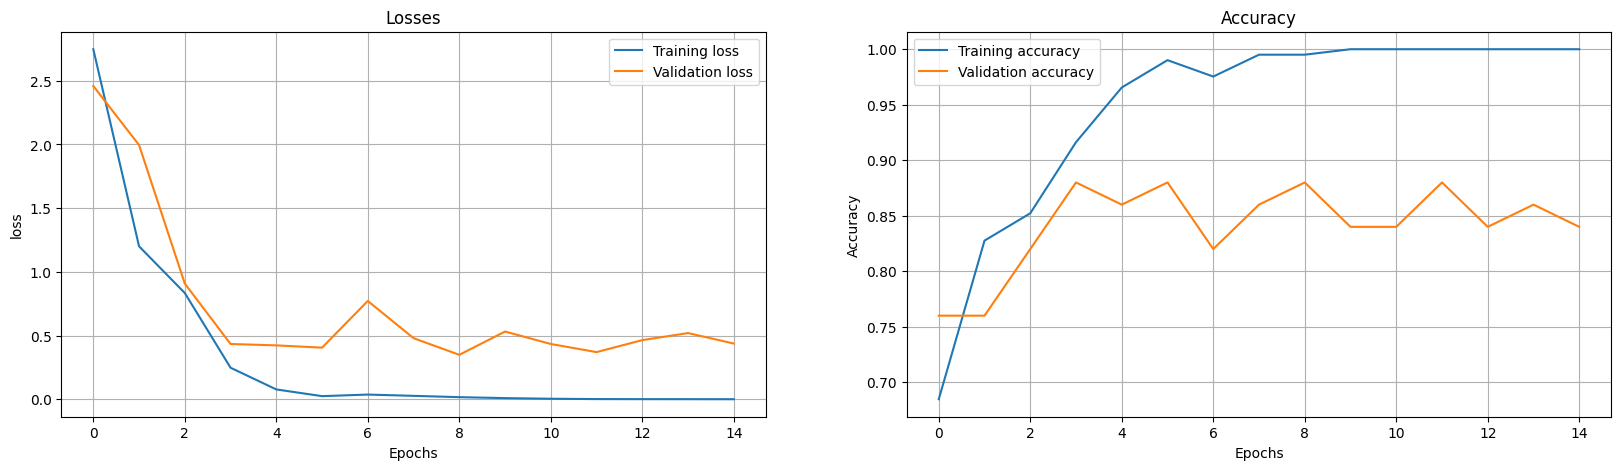

In [ ]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [ ]:
aug_train_ds = augmented_data(height, width)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
                                                 factor=0.3,patience=2, 
                                                 min_lr=0.0000001)
callbacks_list = [checkpoint,early, reduce_lr]

history = model2.fit(aug_train_ds, 
           validation_data=val_ds,
           epochs=30,
           shuffle=True,
           verbose=True,
           callbacks=callbacks_list
          )

Found 253 images belonging to 2 classes.
Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 0.6209 - accuracy: 0.8063 
Epoch 1: accuracy did not improve from 1.00000
8/8 [==============================] - 258s 32s/step - loss: 0.6209 - accuracy: 0.8063 - val_loss: 0.3381 - val_accuracy: 0.9000 - lr: 0.0100
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 1.5968 - accuracy: 0.7115 
Epoch 2: accuracy did not improve from 1.00000
8/8 [==============================] - 259s 32s/step - loss: 1.5968 - accuracy: 0.7115 - val_loss: 0.6975 - val_accuracy: 0.8000 - lr: 0.0100
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 1.0079 - accuracy: 0.7628 
Epoch 3: accuracy did not improve from 1.00000
8/8 [==============================] - 241s 31s/step - loss: 1.0079 - accuracy: 0.7628 - val_loss: 0.2911 - val_accuracy: 0.9600 - lr: 0.0100
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 0.5152 - accuracy: 0.8656 
Epoch 4: accuracy di

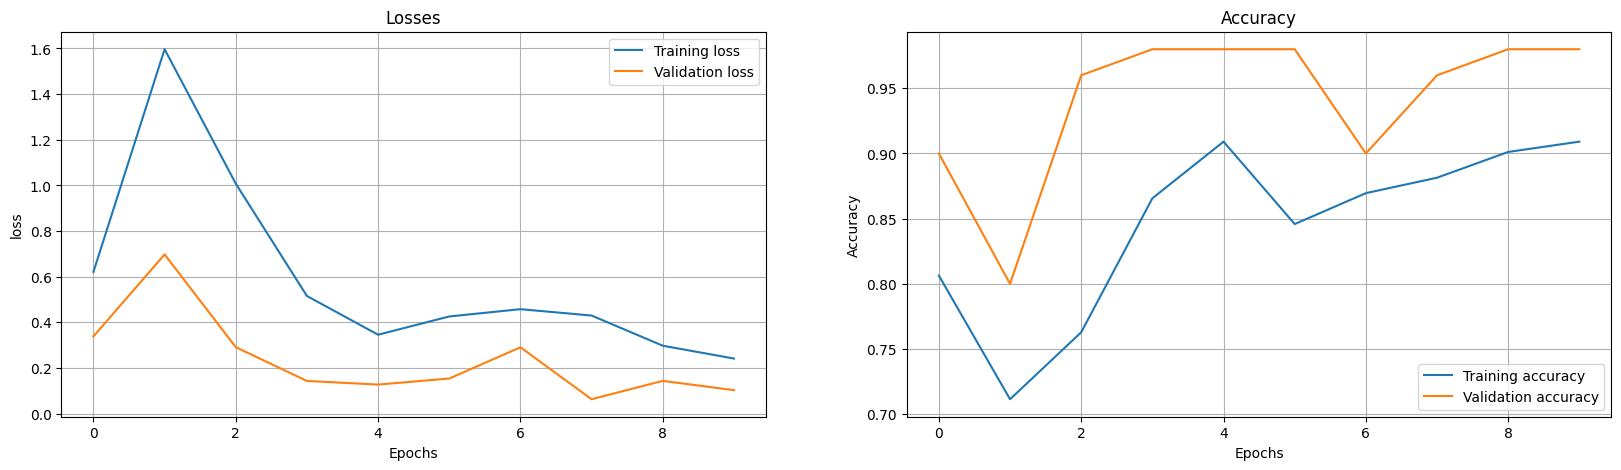

In [18]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [19]:
train_result = model2.evaluate(train_ds)
val_result = model2.evaluate(val_ds)

model2_result = pd.DataFrame(zip(train_result, val_result), 
                             columns=['Train', 'Validation'], 
                             index=['Loss', "Accuracy"])

model2_result

2/2 [==============================] - 38s 13s/step - loss: 0.1271 - accuracy: 0.9800


,Train,Validation
Loss,0.007204,0.127096
Accuracy,1.000000,0.980000


In [20]:
y_pred = model2.predict(val_ds[0][0])
y_pred = np.array([1 if x > 0.5 else 0 for x in y_pred])

y_test = val_ds[0][-1]

#print(y_pred.shape)
#print(y_test.shape)
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score: ", accuracy_score(y_test,y_pred))
print("Classification report:\n", classification_report(y_pred,y_test))

1/1 [==============================] - 26s 26s/step
Confusion matrix:
 [[13  1]
 [ 0 18]]
Accuracy Score:  0.96875
Classification report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.95      0.97        19

    accuracy                           0.97        32
   macro avg       0.96      0.97      0.97        32
weighted avg       0.97      0.97      0.97        32



<Axes: >

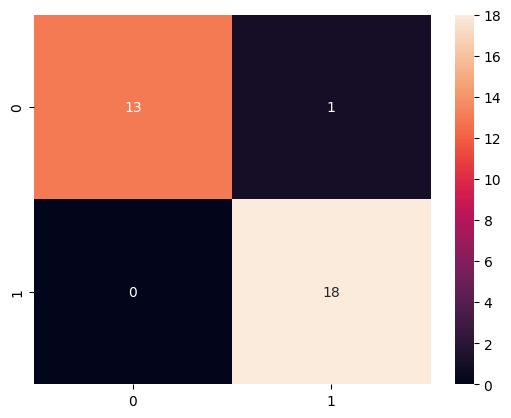

In [21]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

3. InceptionV3

We will use InceptionV3 pre-trained model from keras. You can read more details about it from here. We will use the pre-trained model as base model and will build a final segement with a Flatten layer and a Dense layer. We will use sigmoid activation for our output layer.

In [ ]:
from keras.applications import InceptionV3
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam

In [22]:
height=299
width=299

train_ds, val_ds = image_gen(height, width)

tf.keras.backend.clear_session()

base_model = InceptionV3(
    input_shape=(height, width,3),
    weights='imagenet',
    include_top=False
)

base_model.trainable = False

model3 = Sequential([
    base_model,
    Flatten(),
    Dense(1, activation='sigmoid')
])

model3.compile(loss="binary_crossentropy", optimizer=Adam(0.01), metrics=['accuracy'])

model3.summary()

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1)                 131073    
                                                                 
Total params: 21,933,857
Trainable params: 131,073
Non-trainable params: 21,802,784
_________________________________________________________________


In [23]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/inceptionv3_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max",
                                         restore_best_weights=True, patience=5)

callback_lsit = [checkpoint, early]

history = model3.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callback_lsit)

Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 64.9397 - accuracy: 0.5813
Epoch 1: accuracy improved from -inf to 0.58128, saving model to model/inceptionv3_best.h5
7/7 [==============================] - 80s 11s/step - loss: 64.9397 - accuracy: 0.5813 - val_loss: 51.0313 - val_accuracy: 0.5000
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 29.6243 - accuracy: 0.6946
Epoch 2: accuracy improved from 0.58128 to 0.69458, saving model to model/inceptionv3_best.h5
7/7 [==============================] - 66s 9s/step - loss: 29.6243 - accuracy: 0.6946 - val_loss: 14.7000 - val_accuracy: 0.9200
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 8.6253 - accuracy: 0.8768
Epoch 3: accuracy improved from 0.69458 to 0.87685, saving model to model/inceptionv3_best.h5
7/7 [==============================] - 65s 10s/step - loss: 8.6253 - accuracy: 0.8768 - val_loss: 15.5678 - val_accuracy: 0.8800
Epoch 4/30
7/7 [==============================] - ETA: 

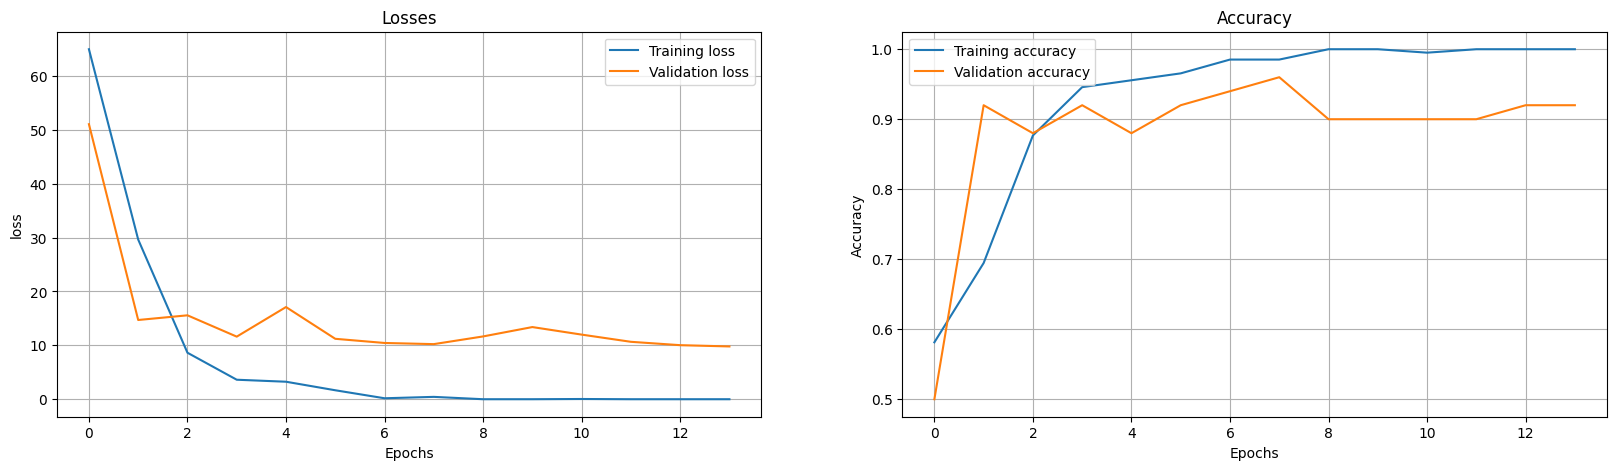

In [24]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [25]:
aug_train_ds = augmented_data(height, width)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3,
                              patience=3, min_lr=0.0000001)
callback_lsit = [checkpoint, early, reduce_lr]

history = model3.fit(aug_train_ds, validation_data=val_ds, epochs=30, callbacks=callback_lsit)

Found 253 images belonging to 2 classes.
Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 12.9844 - accuracy: 0.8498
Epoch 1: accuracy did not improve from 1.00000
8/8 [==============================] - 97s 12s/step - loss: 12.9844 - accuracy: 0.8498 - val_loss: 5.6366 - val_accuracy: 0.8800 - lr: 0.0100
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 7.7376 - accuracy: 0.8814
Epoch 2: accuracy did not improve from 1.00000
8/8 [==============================] - 85s 11s/step - loss: 7.7376 - accuracy: 0.8814 - val_loss: 1.2247 - val_accuracy: 0.9400 - lr: 0.0100
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 8.2786 - accuracy: 0.8696
Epoch 3: accuracy did not improve from 1.00000
8/8 [==============================] - 84s 11s/step - loss: 8.2786 - accuracy: 0.8696 - val_loss: 4.0149 - val_accuracy: 0.8800 - lr: 0.0100
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 5.2172 - accuracy: 0.9091
Epoch 4: accuracy did not

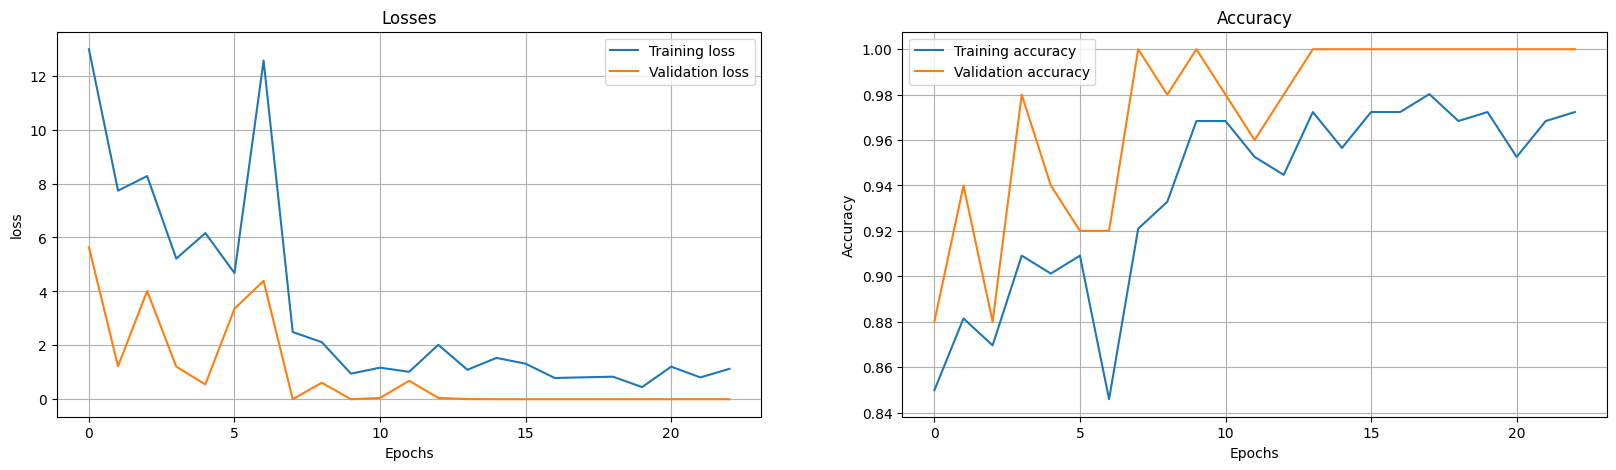

In [26]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [27]:
train_result = model3.evaluate(train_ds)
val_result = model3.evaluate(val_ds)

model3_result = pd.DataFrame(zip(train_result, val_result), 
                             columns=['Train', 'Validation'], 
                             index=['Loss', "Accuracy"])

model3_result

2/2 [==============================] - 13s 4s/step - loss: 3.5060e-13 - accuracy: 1.0000


,Train,Validation
Loss,2.257960e-16,3.506042e-13
Accuracy,1.000000e+00,1.000000e+00


In [28]:
y_pred = model3.predict(val_ds[0][0])
y_pred = np.array([1 if x > 0.5 else 0 for x in y_pred])

y_test = val_ds[0][-1]

#print(y_pred.shape)
#print(y_test.shape)
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score: ", accuracy_score(y_test,y_pred))
print("Classification report:\n", classification_report(y_pred,y_test))

1/1 [==============================] - 9s 9s/step
Confusion matrix:
 [[13  0]
 [ 0 19]]
Accuracy Score:  1.0
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        19

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



<Axes: >

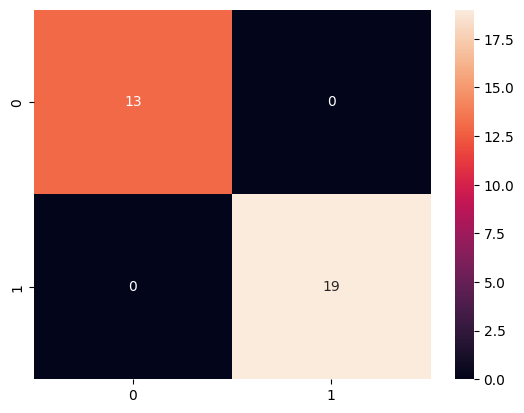

In [29]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

Conclusion

We have a great results on our all three models. With data augmentation, we have increased the validation accuracy(val_accuray) significatly also reduced over-fitting to the training dataset. Since we had a really small dataset, the models might overfit to the train and validation data which can be reduced by adding more data. Overall we have achieved a great results.

A little comparison between the three models:


                train_Accuracy   val_accuracy    f1_score

ResNet50V2:

                  99%            ~96%          0.97
VGG19:

                 100%           ~100%          1.00                        
InceptionV3:

                 100%           ~98%          1.00